# GeoEPIC Tutorial

- This notebook is an end-to-end tutorial for the **GeoEPIC** Python package. 
- It walks through input file preparation, single-site and batched simulations, and model **calibration workflow**.

<!-- ![Overview](./tutorial_assests/geo_epic_overview.png) -->
<div align="center">
<img src="./tutorial_assests/geo_epic_overview.png" width="600">
</div>

## 1) Prerequisites & Installation

**Requirements:**
- Windows OS
- VSCode or similar IDE (Recommended)
- Anaconda package manager

**Recommended setup :**

1. Download the setup script from: https://smarsgroup.github.io/geo_epic_win/epic_setup.bat and execute the below commands in command prompt.

    ```bat
    call epic_setup.bat
    conda activate epic_env
    ```
    The setup script will install Anaconda if it doesn't exist already, then creates a new conda environment named `epic_env` with GeoEPIC installed. 

2. Change the Python kernel of this notebook to the `epic_env` conda environment. Run the cell below to verify the installation 

In [1]:
import sys
sys.path.append(r'C:\Users\iambh\OneDrive\Documents\projects\geo_epic\geo_epic_win\src')

try:
    from geoEpic.io import SOL, DLY, OPC, SIT
    from geoEpic.core import Site, EPICModel, Workspace
except Exception as e:
    print("GeoEPIC not detected.")
# from geoEpic.io import SOL, DLY, OPC, SIT
try:
    import pygmo as pg
except Exception as e:
    print("PyGMO not detected.")

# print("GeoEPIC detected.")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2) Create a GeoEPIC Workspace

The below command creates a sample workspace folder named `Test` with sample input files, and the EPIC executable.

```bash
geo_epic workspace -new Test
```

In [3]:
!geo_epic workspace -new Test

'geo_epic' is not recognized as an internal or external command,
operable program or batch file.


Structure of a workspace folder is as shown below:

- 📁 Test
  - 📁 model  
    - ⚙️ EPIC1102.exe  
    - 📄 CROPCOM.DAT  
    - 📄 PARM.DAT  
    - 📄 EPICRUN.DAT  
    . . . . . . 
  - 📁 opc  
  - 📁 soil  
  - 📁 site  
  - 📁 weather
  - ⚙️ config.yml  
  - 🗒️ info.csv  


In [4]:
from pathlib import Path
workspace_dir = Path(r'C:\Users\iambh\OneDrive\Documents\projects\geo_epic\Test')

## 3) Input files Preparation

`geoEpic.sptial` module provides helpers to build EPIC input files from spatial datasets:
 - Soil Data: [`USDA-SSURGO`](https://www.nrcs.usda.gov/resources/data-and-reports/soil-survey-geographic-database-ssurgo), [`ISIRC-SoilGrids`](https://soilgrids.org/)
 - Daily Weather: [`Daymet`](https://daymet.ornl.gov/), [`AgEra5`](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators)
 - Elevation, Slope: [`GLO-30`](https://registry.opendata.aws/copernicus-dem/), [`SRTM`](https://www2.jpl.nasa.gov/srtm/)

These examples require internet access and proper credentials setup.

### Study Region: Mead, Nebraska
<!-- <div align="center"> 08/08/2023 -->
<div style="display: flex; gap: 30px;">
   <div style="width: 30%; text-align: center;">
    <img src="./tutorial_assests/fileds_NE_18ft.png" style="width: 100%;">
    <p>Mead, Nebraska (Landsat-8)</p>
  </div>
  <div style="width: 30%; text-align: center;">
    <img src="./tutorial_assests/USDA_NASS_CDL.png" style="width: 100%;">
    <p>
      USDA NASS CDL (2023)<br>
      <span style="display: inline-block; width: 12px; height: 12px; background-color: yellow; border: 1px solid #ccc; margin-right: 5px;"></span> Corn  
      <span style="display: inline-block; width: 12px; height: 12px; background-color: green; border: 1px solid #ccc; margin-left: 15px; margin-right: 5px;"></span> Soybean
    </p>
  </div>
  <!-- <div style="width: 30%; text-align: center;">
    <img src="./tutorial_assests/your_third_image.png" style="width: 100%;">
    <p>📊 [Your Third Image Description Here]</p>
  </div> -->
</div>
<!-- </div> -->

[USDA - Crop-Sequence_Boundaries](https://www.nass.usda.gov/Research_and_Science/Crop-Sequence-Boundaries/index.php)

<Axes: >

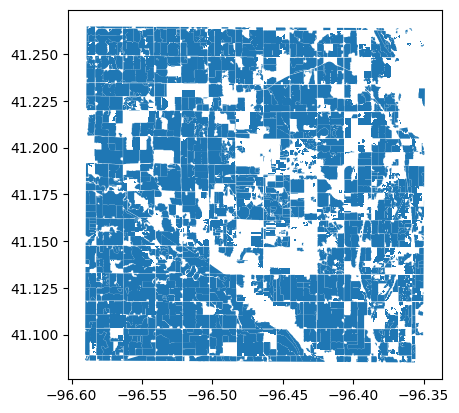

In [5]:
import geopandas as gpd
# Load the shapefile for Mead, Nebraska study area
mead_ne_shp = gpd.read_file(r'C:\Users\iambh\OneDrive\Documents\projects\geo_epic\Test_ET\Mead_NE_shp')
mead_ne_shp.plot()

In [6]:
# location of NE-2 site
lat, lon = 41.1649, -96.4701

#####  3.1) Creating Soil files

In [7]:
workspace_dir

WindowsPath('C:/Users/iambh/OneDrive/Documents/projects/geo_epic/Test')

In [8]:
from geoEpic.spatial import SSURGO, SoilGrids
from geoEpic.io import SOL

#fetch soil data from USDA SSURGO
soil_ssurgo = SSURGO.fetch(lat=lat, lon=lon)
# soil_ssurgo.save(workspace_dir/'soil'/'Ne2.SOL')
soil_ssurgo.layers_df.head()

,mukey,Layer_number,Layer_depth,Bulk_Density,Wilting_capacity,Field_Capacity,Sand_content,Silt_content,N_concen,pH,...,cnds,pkrz,rsd,Bulk_density_dry,psp,Saturated_conductivity,albedo,slope_length,hydgrp_conv,hydgrp
0,1691417,0.0,0.18,1.30,0.150,0.297,10.0,68.0,0.0,5.3,...,0.0,0.0,0.0,1.48,0.0,32.400,0.1,76.0,4.0,0.0
1,1691417,0.0,0.38,1.30,0.101,0.259,12.0,72.0,0.0,5.8,...,0.0,0.0,0.0,1.48,0.0,32.400,0.1,76.0,4.0,0.0
2,1691417,0.0,1.57,1.15,0.256,0.326,5.3,44.7,0.0,7.0,...,0.0,0.0,0.0,1.43,0.0,0.756,0.1,76.0,4.0,0.0
3,1691417,0.0,2.03,1.20,0.190,0.323,7.5,54.5,0.0,7.4,...,0.0,0.0,0.0,1.49,0.0,0.756,0.1,76.0,4.0,0.0


In [9]:
soil_ssurgo.save('./Ne2.SOL')

In [10]:
#load an existing SOL file 
soil = SOL.load(workspace_dir/'soil'/'Ne2.SOL')
soil_ssurgo.layers_df.head()

,Layer_depth,Bulk_Density,Wilting_capacity,Field_Capacity,Sand_content,Silt_content,N_concen,pH,Sum_Bases,Organic_Carbon,Calcium_Carbonate,Cation_exchange,Course_Fragment,cnds,pkrz,rsd,Bulk_density_dry,psp,Saturated_conductivity
0,0.18,1.30,0.150,0.297,10.0,68.0,0.0,5.3,0.0,1.740,0.0,22.5,0.0,0.0,0.0,0.0,1.48,0.0,32.400
1,0.38,1.30,0.101,0.259,12.0,72.0,0.0,5.8,0.0,0.870,0.0,15.0,0.0,0.0,0.0,0.0,1.48,0.0,32.400
2,1.57,1.15,0.256,0.326,5.3,44.7,0.0,7.0,0.0,0.435,0.0,31.5,0.0,0.0,0.0,0.0,1.43,0.0,0.756
3,2.03,1.20,0.190,0.323,7.5,54.5,0.0,7.4,0.0,0.435,0.0,31.5,0.0,0.0,0.0,0.0,1.49,0.0,0.756


In [ ]:
soil_grids = SoilGrids.fetch(lat=lat, lon=lon) #ISIRC soilgrids
soil_grids.layers_df.head()

#####  3.2) Weather files

In [12]:
from geoEpic.spatial import Daymet, AgEra5
from geoEpic.io import DLY

dly_daymet = Daymet.fetch(lat = lat, lon = lon, 
                          start_date = '2015-01-01', 
                          end_date   = '2020-12-31')

# dly_era5 = AgEra5.fetch(lat=lat, lon=lon)
dly_daymet.save(workspace_dir/'weather'/'Ne2.DLY')

In [13]:
dly_daymet = DLY.load(workspace_dir/'weather'/'Ne2.DLY')
dly_daymet.head()

,year,month,day,srad,tmax,tmin,prcp,rh,ws
0,2015,1,1,8.75,1.86,-17.75,0.00,0.45,3.7
1,2015,1,2,6.84,0.70,-11.17,0.00,0.63,1.8
2,2015,1,3,7.05,1.18,-11.14,1.69,0.62,3.2
3,2015,1,4,4.01,-12.44,-18.46,0.00,0.77,7.8
4,2015,1,5,7.47,-4.71,-17.73,0.00,0.58,4.3


In [14]:
from geoEpic.spatial import Daymet, AgEra5
dly_era5 = AgEra5.fetch(lat=lat, lon=lon)
dly_era5

Config is ... {'project': 'ee-my-bharathc'}
'NoneType' object has no attribute 'items'


,Date,srad,tmax,tmin,prcp,rh,ws,year,month,day
0,2018-01-01,37.006,-8.619,-11.266,0.00,78.123,4.747,2018,1,1
1,2018-01-02,36.562,-7.516,-11.194,0.00,79.321,5.189,2018,1,2
2,2018-01-03,36.378,-7.981,-10.870,0.00,79.072,4.556,2018,1,3
3,2018-01-04,34.277,-7.301,-11.240,0.00,82.040,3.727,2018,1,4
4,2018-01-05,34.774,-8.396,-10.503,0.00,83.914,3.745,2018,1,5
...,...,...,...,...,...,...,...,...,...,...
724,2019-12-26,32.212,-5.282,-10.881,0.50,85.733,3.184,2019,12,26
725,2019-12-27,35.096,-7.552,-11.255,0.01,84.100,2.522,2019,12,27
726,2019-12-28,34.815,-8.119,-10.762,0.00,84.235,2.382,2019,12,28
727,2019-12-29,34.618,-9.419,-10.981,0.01,86.506,2.362,2019,12,29


#####  3.3) SIT files

In [15]:
from geoEpic.spatial import DEM
from geoEpic.io import SIT

elevation, slope = DEM.fetch(lat=lat, lon=lon)

ne_site = SIT()
ne_site.lat = lat
ne_site.lon = lon
ne_site.elevation = elevation
ne_site.slope = slope
ne_site.save(str(workspace_dir/'sites'/'Ne2.SIT'))

print('elevation: ', elevation)
print('slope: ', slope)

Config is ... {'project': 'ee-my-bharathc'}
elevation:  355.5377197265625
slope:  0.0005103278005493831


#### 3.4) Editing Crop Management files

- The crop management file contains information about management practices carried out at the specific site. 
- Each row represents a specific management operation, including crop planting, fertilizer applications, irrigation scheduling, harvesting, and tillage practices.
- The structure and valid entries for `OPC` files are detailed in the [`EPIC1102` user manual](./tutorial_assests/epic1102-user-manual.pdf#page=69).

In [16]:
from geoEpic.io import OPC
opc = OPC.load(workspace_dir/'opc'/'Ne2.OPC')
opc.head(10)

,Yid,Mn,Dy,CODE,TRAC,CRP,XMTU,OPV1,OPV2,OPV3,OPV4,OPV5,OPV6,OPV7,OPV8,Yr,date
0,1.0,5.0,12.0,2.0,0.0,1.0,0.0,1687.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-05-12
1,1.0,10.0,3.0,650.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-10-03
2,1.0,10.0,3.0,41.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-10-03
3,2.0,4.0,30.0,71.0,0.0,2.0,52.0,115.447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-04-30
4,2.0,5.0,2.0,2.0,0.0,2.0,0.0,2262.215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-05-02
5,2.0,6.0,12.0,71.0,0.0,2.0,52.0,33.625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-06-12
6,2.0,6.0,27.0,71.0,0.0,2.0,52.0,160.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-06-27
7,2.0,11.0,5.0,650.0,0.0,2.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-11-05
8,2.0,11.0,6.0,41.0,0.0,2.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-11-06
9,3.0,5.0,14.0,2.0,0.0,1.0,0.0,1560.535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,2008-05-14


In [17]:
# Select auto irrigation implement ID
# opc.IAUI = 72
# Apply fertilizer 
fertilizer = {'opID':71, 'cropID':2, 'fertID':52,'date': '2015-04-01', 'OPV1': 160}
opc.update(fertilizer)
# Remove certain operation(s)
opc.remove(opID=71, date='2007-04-30')
opc.head(10)

C:\Users\iambh\OneDrive\Documents\projects\geo_epic\geo_epic_win\src\geoEpic\io\inputs\opc.py:194: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.loc[len(self)] = new_row


,Yid,Mn,Dy,CODE,TRAC,CRP,XMTU,OPV1,OPV2,OPV3,OPV4,OPV5,OPV6,OPV7,OPV8,Yr,date
0,1.0,5.0,12.0,2.0,0.0,1.0,0.0,1687.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-05-12
1,1.0,10.0,3.0,650.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-10-03
2,1.0,10.0,3.0,41.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2006-10-03
3,2.0,5.0,2.0,2.0,0.0,2.0,0.0,2262.215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-05-02
4,2.0,6.0,12.0,71.0,0.0,2.0,52.0,33.625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-06-12
5,2.0,6.0,27.0,71.0,0.0,2.0,52.0,160.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-06-27
6,2.0,11.0,5.0,650.0,0.0,2.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-11-05
7,2.0,11.0,6.0,41.0,0.0,2.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,2007-11-06
8,3.0,5.0,14.0,2.0,0.0,1.0,0.0,1560.535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,2008-05-14
9,3.0,10.0,10.0,650.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,2008-10-10


## 6) Single-site simulation (`Site`, `EPICModel`)

In [18]:
from geoEpic.core import Site, EPICModel

# create a site object
site = Site(
    site_id = 'Ne2',
    opc=str(workspace_dir/'opc'/'Ne2.OPC'),
    dly=str(workspace_dir/'weather'/'Ne2.DLY'),
    sol=str(workspace_dir/'soil'/'Ne2.SOL'),
    sit=str(workspace_dir/'sites'/'Ne2.SIT'),
)

In [19]:
Path(workspace_dir/'outputs').mkdir(exist_ok=True, parents=True)

# Execute the model at this particular site
model = EPICModel(workspace_dir/'model'/'EPIC1102.exe')
model.start_date = '2015-01-01'
model.duration = 5 # years
model.output_types = ['ACY', 'DGN']
model.output_dir = workspace_dir/'outputs'


model.run(site)

model.close()

#### Reading outputs (`ACY`, `DGN`)

In [20]:
from geoEpic.io import ACY, DGN, DWC
yields = ACY(site).get_var('YLDG')
yields

,index,YR,CPNM,YLDG
0,0,2015,SOYB,3.607
1,1,2016,CORN,8.144
2,2,2017,SOYB,3.597
3,3,2018,CORN,4.305
4,4,2019,SOYB,3.139


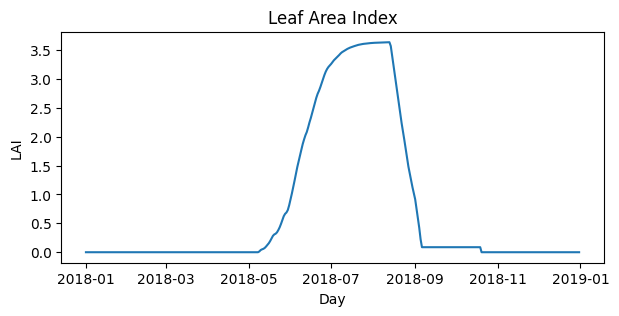

In [21]:
lai = DGN(site).get_var('LAI')
lai = lai[lai['Date'].dt.year == 2018]
plt.figure(figsize=(7, 3))
plt.plot(lai['Date'], lai['LAI'])
plt.title("Leaf Area Index")
plt.xlabel("Day")
plt.ylabel("LAI")
plt.show()

<!-- <div align="center"> -->
 <!-- <img src="./tutorial_assests/corn.png" width="60%"> -->
<!-- </div> -->

## 8) Managing multiple sites with `Workspace` class

The Workspace class is a powerful component of `GeoEPIC` that enables efficient management and execution of `EPIC` simulations across multiple sites, significantly streamlining the workflow for regional-scale agricultural modeling studies. <br>
Workspace object is initialized by two key configuration elements: <br>
(1) configuration file that specifies global simulation settings <br>
(2) run_info file containing metadata on individual simulation sites. 

In [5]:
workspace_dir = Path(r'C:\Users\iambh\OneDrive\Documents\projects\geo_epic\Test_ET')

In [31]:
exp.close()

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\iambh\\OneDrive\\Documents\\projects\\geo_epic\\Test_ET\\.cache\\geo_epic_iambh\\H4DacXnFaHatjqd4YWSxdB\\Xj5jaAWnephWx4SygqAQxV_avg_annual_et'

In [32]:
#initialize Workspace object
exp = Workspace(workspace_dir/'config.yml')

#clear previous logs and outputs
exp.clear_logs()
exp.clear_outputs()

In [33]:
# run the simulations for all the sites
# exp.run()

In [34]:
from geoEpic.io import DGN, ACY, DWC

In [35]:
Path(workspace_dir/'lai_export').mkdir(exist_ok=True, parents=True)
 
# save Yield data to csv files for each site
@exp.routine
def save_lai(site):
    lai = DGN(site).get_var('LAI')
    lai.to_csv(workspace_dir/f'lai_export/{site.site_id}.csv')
    

# calculate average annual ET for soybean and log them
@exp.logger
def avg_annual_et(site):
    daily_et = ACY(site).get_var('GSET')
    annual_et = daily_et.groupby(['CPNM'])['GSET'].mean().reset_index()
    soyb_data = annual_et[annual_et['CPNM'] == 'SOYB']
    avg_et_soyb = soyb_data['GSET'].iloc[0] if not soyb_data.empty else None
    return {'SOYB_ET': avg_et_soyb}

In [36]:
exp.config['select'] = 'Range(0, 0.01)' #change to Range(0, 1)

In [37]:
exp.run()

100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


In [38]:
logged_et = exp.fetch_log('avg_annual_et', keep = True)
logged_et.dropna()

,SiteID,SOYB_ET
0,7834348,272.233333
1,7834349,280.277778
2,7834350,277.671429
3,7834353,245.175000
4,7834355,261.792857
5,7834356,267.862500
6,7834358,235.960000
7,7834359,239.600000
8,7834360,213.507143
9,7834361,226.012500


#### Spatial plot of Average annual Evapotranspiration

<module 'matplotlib.pyplot' from 'c:\\Users\\iambh\\anaconda3\\envs\\epic_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

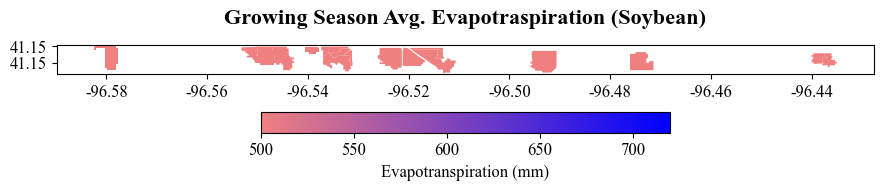

In [39]:
from utils import spatial_plot

spatial_plot(r'C:\Users\iambh\OneDrive\Documents\projects\geo_epic\Test_ET\Mead_NE_shp', logged_et.dropna(), \
    title = 'Growing Season Avg. Evapotraspiration (Soybean)')

<!-- <div align="center"> -->
 <!-- <img src="./tutorial_assests/ET_annual_soybean.png" width="60%"> -->
<!-- </div> -->

## 9) Calibration WorkFlow

The calibration setup involves defining a fitness criterion that quantifies the difference between simulated outputs and observed data and selecting the parameters that significantly influence the required outputs. The figure shows the overview of Calibration iterations in GeoEPIC.

<!-- <div align="center"> -->
 <img src="./tutorial_assests/model_calibration.png" width="60%">
<!-- </div> -->

The steps involved in the setup are shown below:
1. Define a logger to compute per-site error(s) after each simulation.
2. Define an objective to aggregate logged metrics.
3. Mark sensitive parameters in `CropCom`/`Parm`, then build a PyGMO problem via `exp.make_problem(...)`.
4. Choose an algorithm (e.g., PSO) and optimize.

In [ ]:
#select sites where ET column is 1 in info file
exp.config['select'] = 'ET == 1'

@exp.logger
def et_error(site):
    # Get daily ET from EPIC simulation
    daily_et = DWC(site).get_var('ET')
    filtered_data = daily_et[(daily_et['ET'] > 0.05) 
                           & (daily_et['Y'].between(2017, 2020)) 
                           & (daily_et['M'].between(5, 9))]
    
    # Load target ET data for this site
    target_et = pd.read_csv(workspace_dir / f'target_et/{site.site_id}.csv')
    target_et['Date'] = pd.to_datetime(target_et['Date'])
    # Merge on date (intersection)
    merged_data = pd.merge(filtered_data, target_et, on='Date', how='inner')
    # Calculate year-wise error for soybean crop
    # print(merged_data)
    soyb_data = merged_data[(merged_data['CPNM'] == 'SOYB') & (merged_data['select'] == 1)]
    if soyb_data.empty: return {'error': None}
    # Group by year and sum ET values
    err = (soyb_data['ET'] - soyb_data['et_tar'])
    # Calculate year-wise RMSE using numpy
    year_rmse = np.sqrt(np.mean(err**2))
    return {'error': year_rmse}


@exp.objective
def aggregate():
    logged = exp.fetch_log('et_error').dropna()
    return [logged['error'].mean()]

### Compare simulated and observed ET

In [41]:
exp.run()

100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[3.571854034416324]

#### Setting sensitive parameters

In [42]:
from geoEpic.io import CropCom, Parm

cropcom = CropCom(exp.model.path)
cropcom.set_sensitive(['DMLA', 'GSI', 'HMX', 'DLAI', 'PPLP2_v2'], [1]) 
cropcom.get_vars()

,Parameter,Description,Select,Min,Max,Current
4,DMLA,Maximum potential leaf area index,True,4.500,7.000,4.9200
5,DLAI,Fraction of growing season when leaf area decl...,True,0.600,1.000,0.7600
13,GSI,Maximum Stomatal Conductance,True,0.005,0.015,0.0065
16,HMX,Maximum crop height,True,0.500,1.500,0.6300
55,PPLP2_v2,Plant Population Crops & Grass 2nd Point.,True,75.000,99.000,99.0000


In [43]:
cropcom = CropCom(exp.model.path)
cropcom.set_sensitive(['DMLA', 'GSI', 'HMX', 'DLAI', 'PPLP2_v2'], [1]) 
cropcom.get_vars()

,Parameter,Description,Select,Min,Max,Current
4,DMLA,Maximum potential leaf area index,True,4.500,7.000,4.9200
5,DLAI,Fraction of growing season when leaf area decl...,True,0.600,1.000,0.7600
13,GSI,Maximum Stomatal Conductance,True,0.005,0.015,0.0065
16,HMX,Maximum crop height,True,0.500,1.500,0.6300
55,PPLP2_v2,Plant Population Crops & Grass 2nd Point.,True,75.000,99.000,99.0000


In [44]:
parm = Parm(exp.model.path)
parm.set_sensitive(['PARM35'])
parm.get_vars()

,Parameter,Description,Select,Min,Max,Current
94,PARM35,Water stress weighting coefficient,True,0.0,1.0,1.0


In [45]:
parm = Parm(exp.model.path)
parm.set_sensitive(['PARM35'])
parm.get_vars()

,Parameter,Description,Select,Min,Max,Current
94,PARM35,Water stress weighting coefficient,True,0.0,1.0,1.0


#### Create a optimization problem to interface with pygmo library 

In [46]:
problem = exp.make_problem(cropcom, parm)


Refer to the PyGMO [documentation](https://esa.github.io/pygmo2/algorithms.html) to experiment with different algorithms and customizable parameters to find the most effective optimization strategy.

In [47]:
import pygmo as pg

# Initialize the problem with PSO algorithm
problem.init(algorithm = pg.pso_gen, memory=True)
problem.optimize(population_size = 30, generations = 10)

Fitness before optimization: [3.571854034416324]
Setting Initial Population
optimizing...


100%|██████████| 10/10 [03:16<00:00, 19.67s/gen, Best_Fitness=2.60392]

Final best fitness: [2.60391803]


In [ ]:
problem.sensitivity_analysis(100, 'efast')

Sampling using eFAST with 100 samples...
Evaluating objective function for each sample...


  2%|▏         | 12/600 [00:08<06:05,  1.61it/s]


KeyboardInterrupt caught, canceling remaining operations...


  6%|▌         | 33/600 [00:21<06:09,  1.54it/s]

<!-- <code>
<div style="font-family:'Consolas','Courier New',monospace;color:rgb(60, 60, 60)">
Fitness before optimization: [3.0133333]<br>
Setting Initial Population<br>
optimizing...
</div>
<div style="font-family:Consolas,'Courier New',monospace;color:rgb(60,60,60)">
  100%|██████████| 10/10 [11:10<00:00, 67.05s/gen, best_fitness=0.776]<br>
  Final best fitness: [0.776]
</div> -->

## 10) Troubleshooting & Tips

- Check `logs/` for errors occured during model execution.
- Start with a small subset of sites: `select: Random(0.1)` to diagnose errors.
- Edit `.sens` file in the model folder to set valid range for parameters
- Edit `exp.num_of_workers` to expand or constrain the no of parallel simulations.
- Call `exp.close()` before a program exit or restarting the Jupyter notebook for a clean exit.

In [ ]:
exp.close()